In [1]:
import glob, json
import numpy as np
import pandas as pd
from scipy.stats import entropy
import sklearn.decomposition
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

from lib import *
plt.style.use('../peptidome.mplstyle')

In [2]:
proteome = 'Humanviruses'
k = 9
all_data = {}
for i, model in enumerate(['independent', 'ncov', 'nskew', 'nskewfcov']):

    arr = np.load('../classifier/data/{proteome}_{model}_k{k}_likelihoods.npz'.format(proteome=proteome,
                                                                                      model=model, k=k))
    df = pd.read_csv('../maxent/data/{proteome}_{model}_k{k}_dkl.csv'.format(proteome=proteome,
                                                                             model=model, k=k),
                     index_col=0, squeeze=True)
    dkl = df.loc['DKL']
    data = {}

    logp_hh, logp_pp, logp_hp, logp_ph = arr['logp_hh'], arr['logp_pp'], arr['logp_hp'], arr['logp_ph']
    data['logp_hh'], data['logp_pp'], data['logp_hp'], data['logp_ph'] = logp_hh, logp_pp, logp_hp, logp_ph

    positive = logp_pp-logp_ph
    negative = logp_hp-logp_hh
    data['positive'] = np.sort(positive)*np.log10(np.exp(1))
    data['negative'] = np.sort(negative)*np.log10(np.exp(1))
    data['dkl'] = dkl
    
    all_data[model] = data

In [3]:
human_kmers = load_matrix('../maxent/data/Human_test_k{k}_matrix.csv.gz'.format(k=k))
pathogen_kmers = load_matrix('../maxent/data/{proteome}_test_k{k}_matrix.csv.gz'.format(proteome=proteome, k=k))

In [53]:
human_kmers_str = matrix_to_kmers(human_kmers)

In [54]:
pathogen_kmers_str = matrix_to_kmers(pathogen_kmers)

In [55]:
with open('data/human.txt', 'w') as f:
    for item in human_kmers_str[:100000]:
        f.write("%s\n" % item)

In [56]:
with open('data/pathogen.txt', 'w') as f:
    for item in pathogen_kmers_str[:100000]:
        f.write("%s\n" % item)

In [57]:
from lib.netmhcrunutils import run_netMHC

In [129]:
dfhla = pd.read_csv(datadir+'hlas.csv', sep='\t', skiprows=1)
hlas = dfhla['name']
#hlas = ['HLA-A0202']

In [130]:
for hla in hlas:
    run_netMHC('data/human.txt', 'data/human', hla, binder_only=False)

/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/human.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/human-HLA-A0211.csv -a HLA-A0211
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/human.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/human-HLA-A0212.csv -a HLA-A0212
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/human.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/human-HLA-A0216.csv -a HLA-A0216
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/human.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/human-HLA-A0217.csv -a HLA-A0217
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/human.txt -xls -xlsfile /home/amayer/repos/

/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/human.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/human-HLA-B1801.csv -a HLA-B1801
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/human.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/human-HLA-B2705.csv -a HLA-B2705
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/human.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/human-HLA-B2720.csv -a HLA-B2720
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/human.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/human-HLA-B3501.csv -a HLA-B3501
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/human.txt -xls -xlsfile /home/amayer/repos/

In [131]:
for hla in hlas:
    run_netMHC('data/pathogen.txt', 'data/pathogen', hla, binder_only=False)

/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/pathogen.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/pathogen-HLA-A0101.csv -a HLA-A0101
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/pathogen.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/pathogen-HLA-A0201.csv -a HLA-A0201
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/pathogen.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/pathogen-HLA-A0203.csv -a HLA-A0203
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/pathogen.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/pathogen-HLA-A0205.csv -a HLA-A0205
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/pathogen.txt -xls -

/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/pathogen.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/pathogen-HLA-B0803.csv -a HLA-B0803
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/pathogen.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/pathogen-HLA-B1402.csv -a HLA-B1402
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/pathogen.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/pathogen-HLA-B1501.csv -a HLA-B1501
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/pathogen.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/pathogen-HLA-B1502.csv -a HLA-B1502
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/pathogen.txt -xls -

/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/pathogen.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/pathogen-HLA-C1203.csv -a HLA-C1203
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/pathogen.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/pathogen-HLA-C1402.csv -a HLA-C1402
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/pathogen.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/pathogen-HLA-C1502.csv -a HLA-C1502
/home/amayer/repos/peptidome/dependencies/netMHC-4.0/netMHC -f /home/amayer/repos/peptidome/code/netmhc/data/pathogen.txt -xls -xlsfile /home/amayer/repos/peptidome/code/netmhc/data/pathogen-HLA-E0101.csv -a HLA-E0101


In [132]:
proteome = 'Humanviruses'
model = 'nskewfcov'
arr = np.load('../classifier/data/{proteome}_{model}_k{k}_likelihoods.npz'.format(proteome=proteome,
                                                                                      model=model, k=k))
prob_ratio_pathogen = (arr['logp_pp'] - arr['logp_ph'])[:100000]
prob_ratio_human = (arr['logp_hp'] - arr['logp_hh'])[:100000]
prob_pathogen = arr['logp_pp'][:100000]
prob_human = arr['logp_hh'][:100000]

In [133]:
proteome = 'pathogen'
correlations_pathogen = []
correlations_pathogen_ratio = []
correlations_pathogen_ratio_abs = []

for hla in hlas:
    df = pd.read_csv('data/{proteome}-{hla}.csv'.format(proteome=proteome, hla=hla), sep='\t', skiprows=1)
    corr, pval = scipy.stats.spearmanr(prob_pathogen, np.array(df['nM']))
    correlations_pathogen.append(corr)
    corr, pval = scipy.stats.spearmanr(prob_ratio_pathogen, np.array(df['nM']))
    correlations_pathogen_ratio.append(corr)
    corr, pval = scipy.stats.spearmanr(np.abs(prob_ratio_pathogen), np.array(df['nM']))
    correlations_pathogen_ratio_abs.append(corr)

In [134]:
proteome = 'human'
correlations_human = []
correlations_human_ratio = []
correlations_human_ratio_abs = []
for hla in hlas:
    df = pd.read_csv('data/{proteome}-{hla}.csv'.format(proteome=proteome, hla=hla), sep='\t', skiprows=1)
#    q = np.quantile(df['nM'], 0.01)
    corr, pval = scipy.stats.spearmanr(prob_human, np.array(df['nM']))
    correlations_human.append(corr)
    corr, pval = scipy.stats.spearmanr(prob_ratio_human, np.array(df['nM']))
    correlations_human_ratio.append(corr)
    corr, pval = scipy.stats.spearmanr(np.abs(prob_ratio_human), np.array(df['nM']))
    correlations_human_ratio_abs.append(corr)

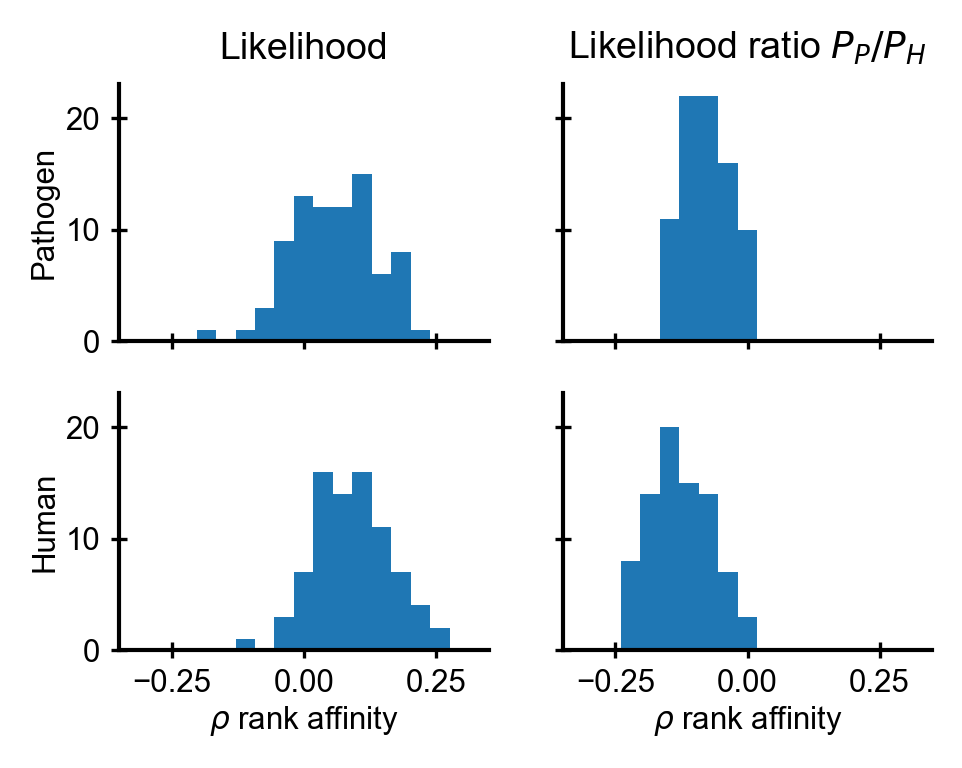

In [135]:
fig, axes = plt.subplots(figsize=(3.5, 2.5), nrows=2, ncols=2, sharex=True, sharey=True)
bins = np.linspace(-0.35, 0.35, 20)
axes[0, 0].hist(correlations_pathogen, bins=bins)
axes[0, 0].set_ylabel('Pathogen')
axes[0, 0].set_title('Likelihood')
axes[0, 1].hist(correlations_pathogen_ratio, bins=bins)
axes[0, 1].set_title('Likelihood ratio $P_P/P_H$')
#axes[0, 2].hist(correlations_pathogen_ratio_abs, bins=bins);
#axes[0, 2].set_title('Abs(Likelihood ratio)')
axes[1, 0].hist(correlations_human, bins=bins)
axes[1, 0].set_ylabel('Human')
axes[1, 1].hist(correlations_human_ratio, bins=bins)
#axes[1, 2].hist(correlations_human_ratio_abs, bins=bins);
axes[0, 0].set_xlim(min(bins), max(bins))
for i in range(2):
    axes[1, i].set_xlabel(r'$\rho$ rank affinity')
fig.savefig('netmhc_correlations.pdf')

In [73]:
sys.path.append('/home/amayer/repos/tcr_space/code')
import tcrspacelib as tl

In [93]:
prob_ratios = {}
prob_ratios['human'] = prob_ratio_human
prob_ratios['pathogen'] = prob_ratio_pathogen

In [97]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

In [136]:
probs = dict(human=prob_human, pathogen=prob_pathogen)

In [140]:
np.mean(np.array(df['nM'])<500)

0.00937

HLA-B4001


/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs


HLA-A2501


/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs


HLA-A0101


/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs


HLA-A6801


/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs


HLA-B5401


/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs


HLA-B5101


/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs


HLA-B4002


/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs


HLA-A0250


/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs


HLA-B2705


/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs


HLA-C0501


/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs


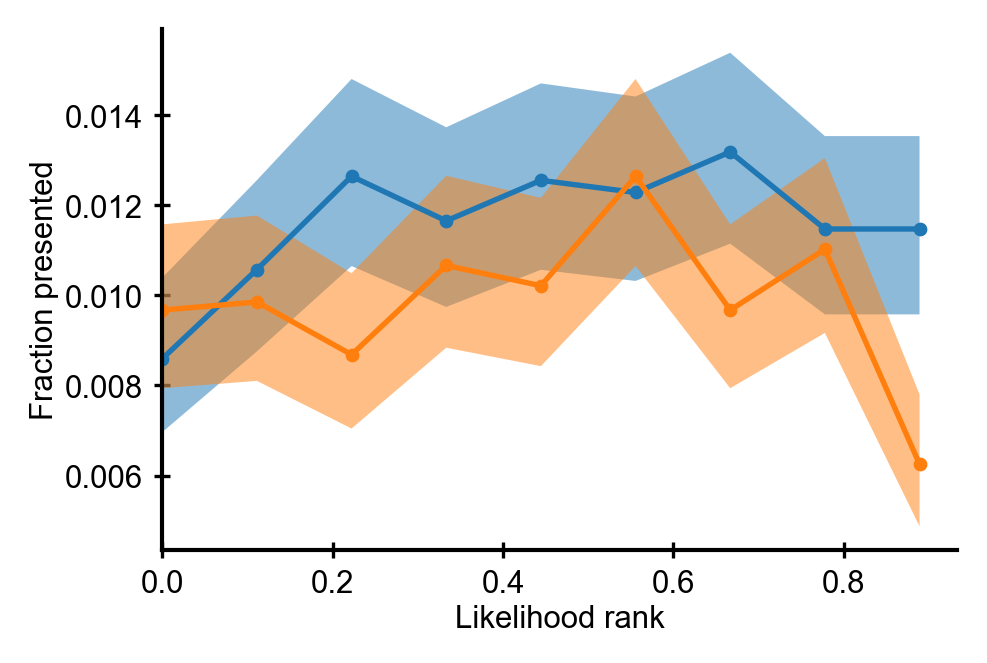

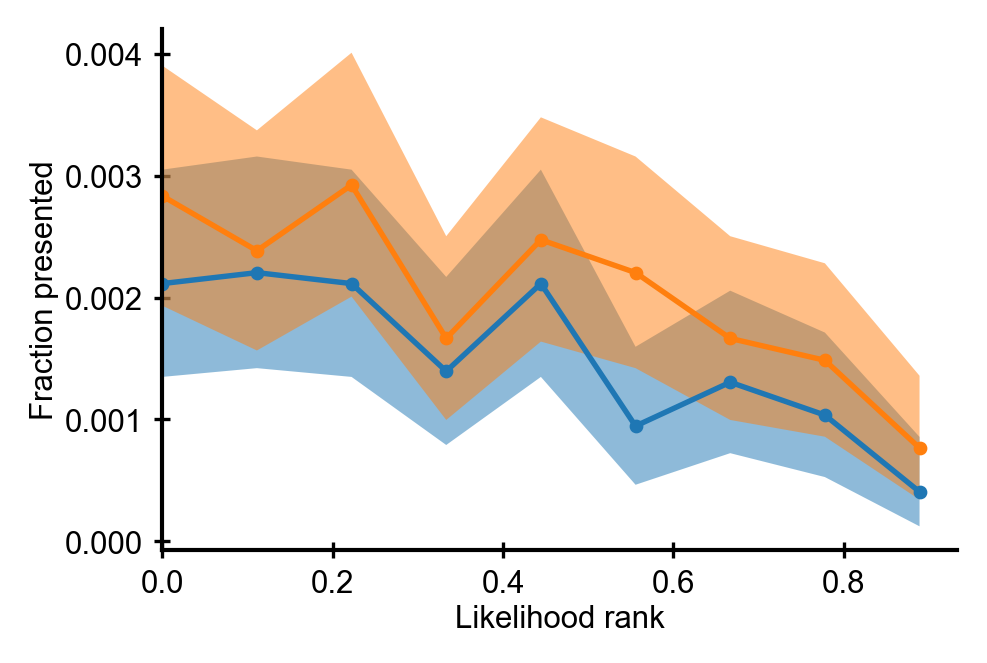

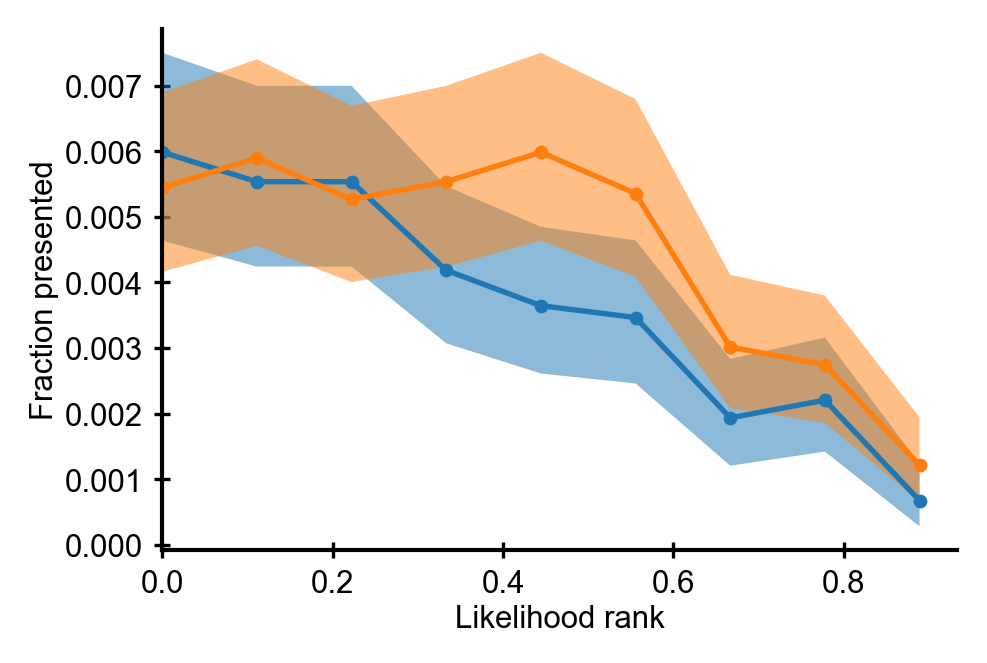

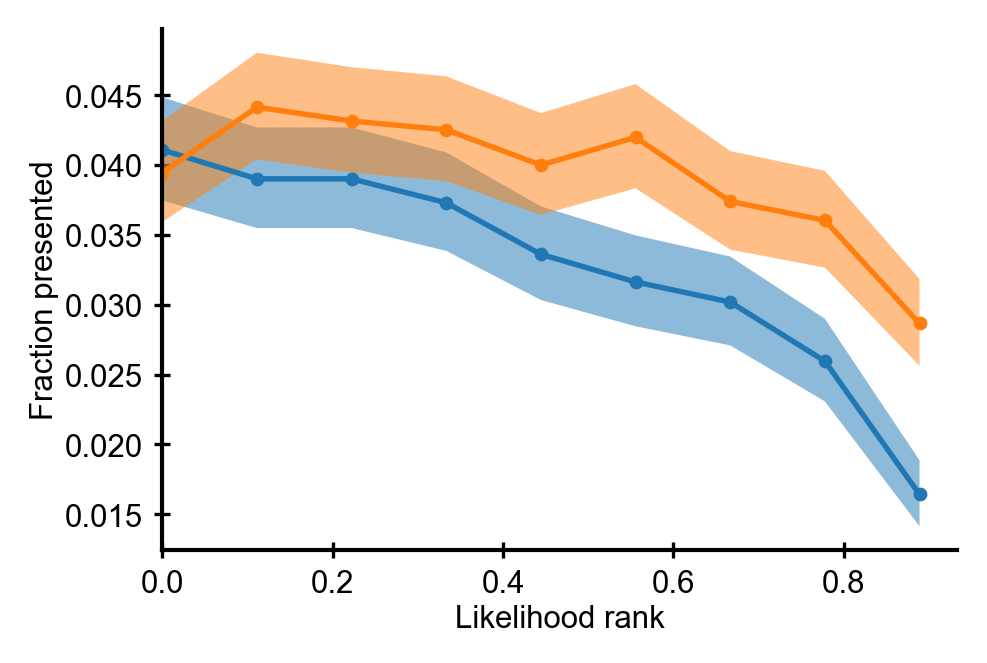

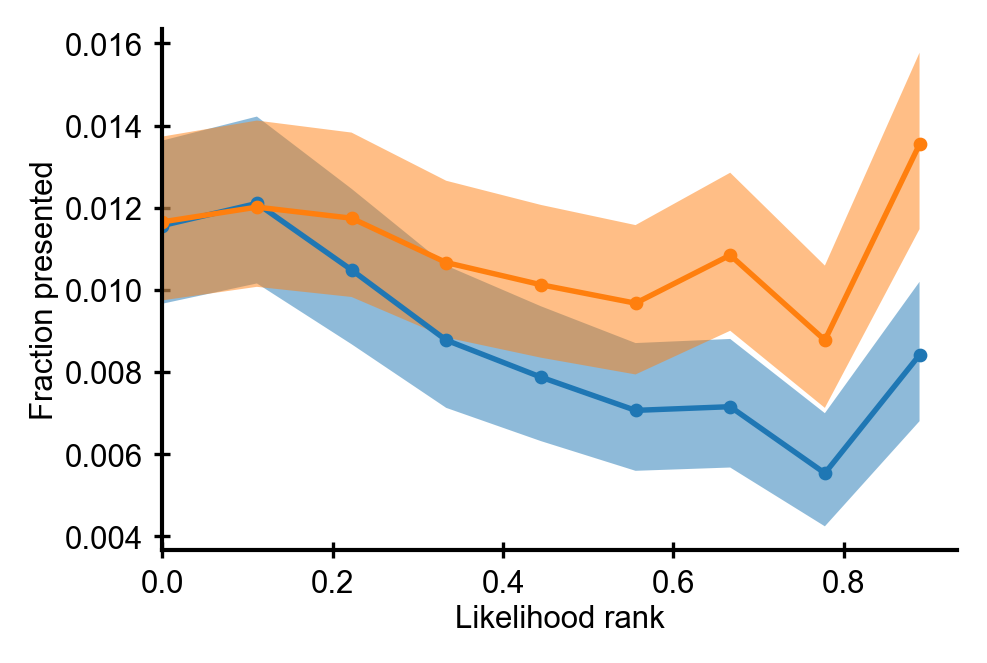

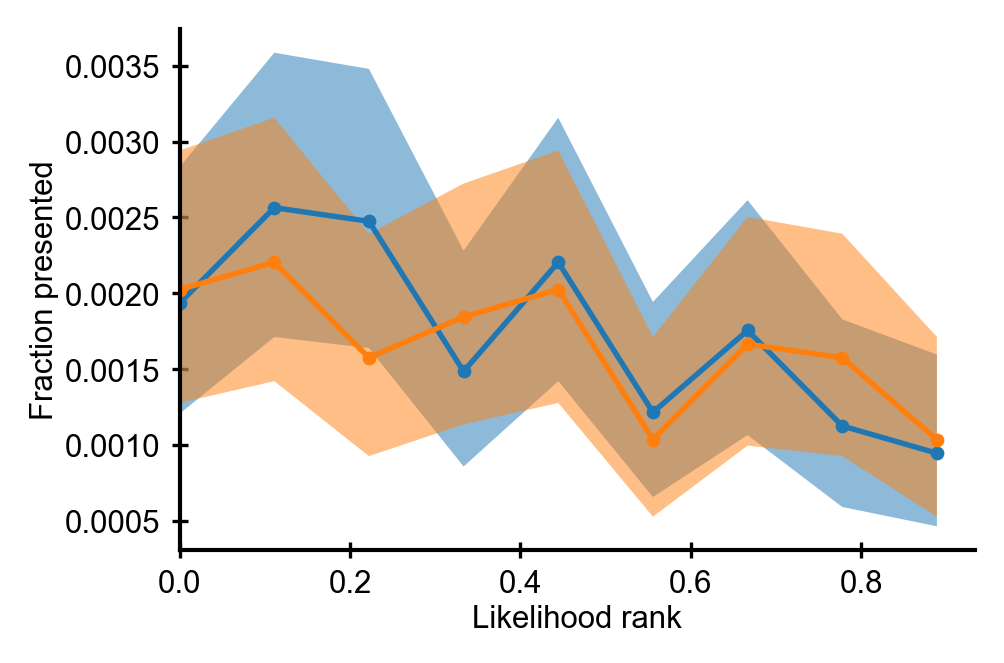

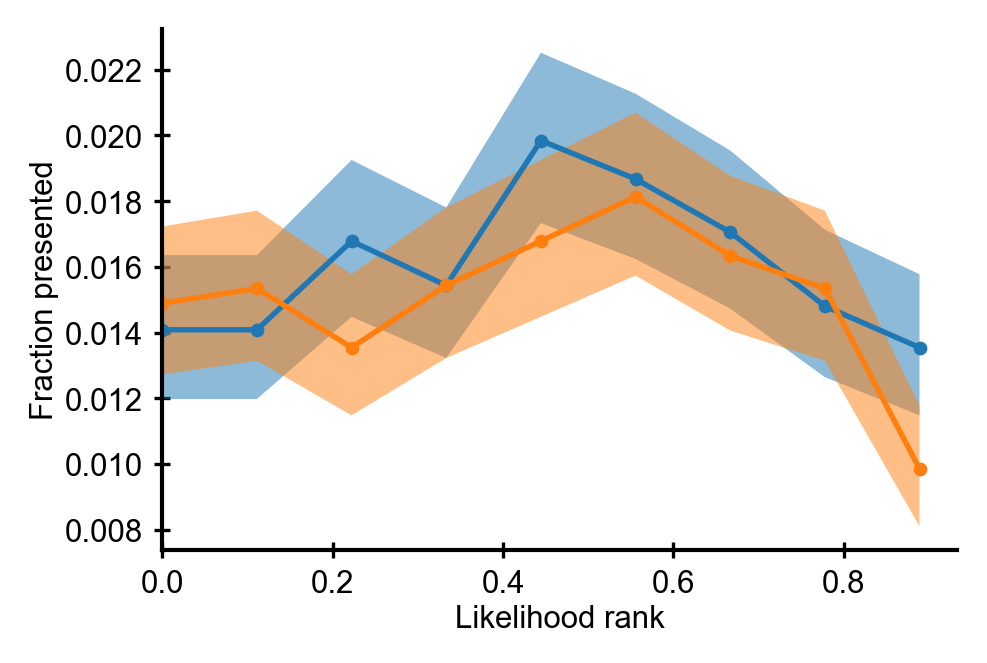

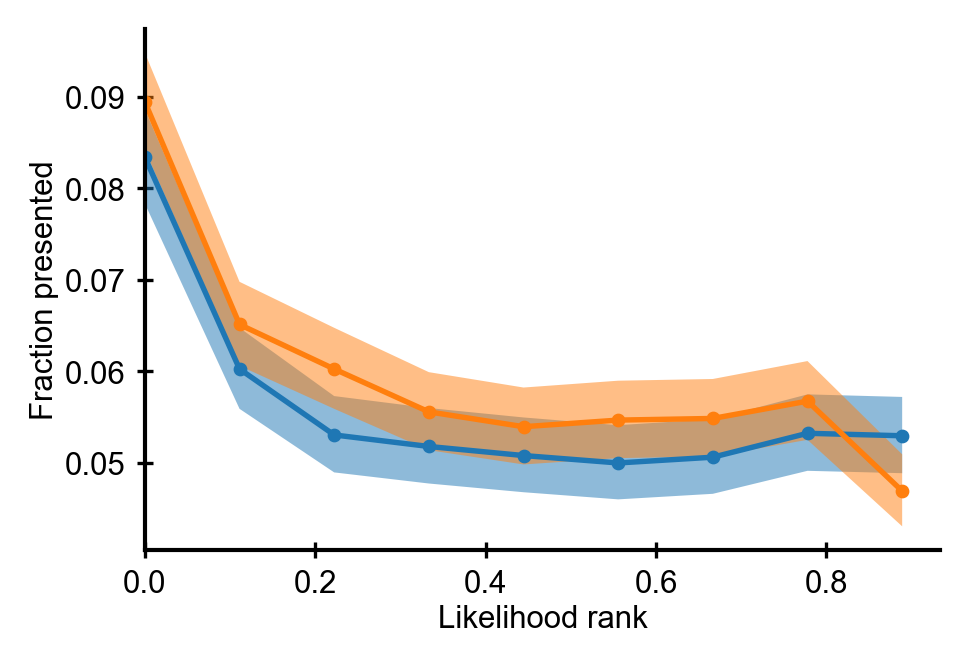

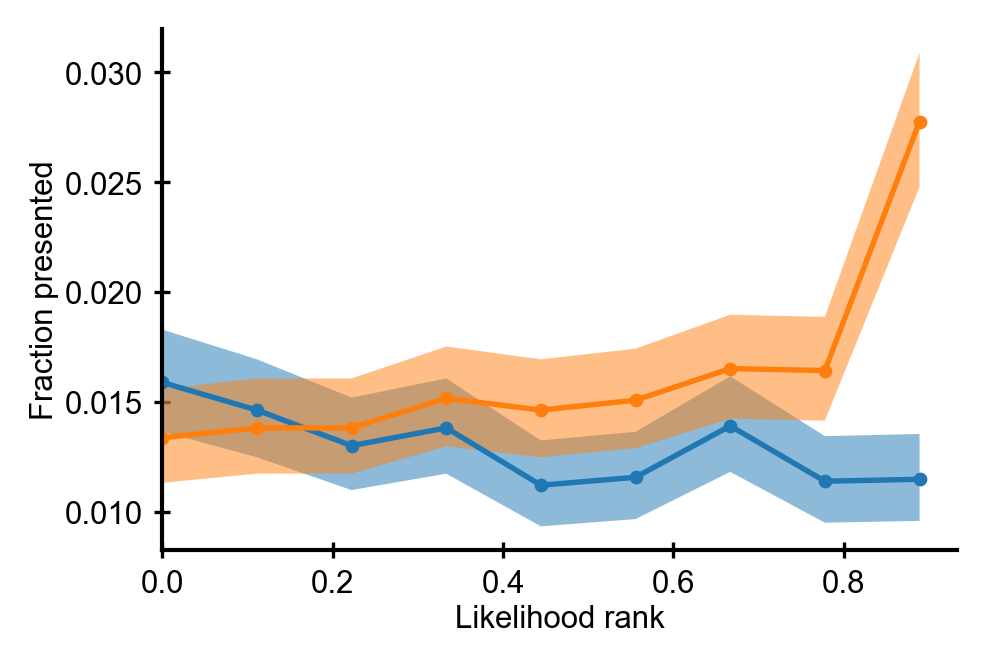

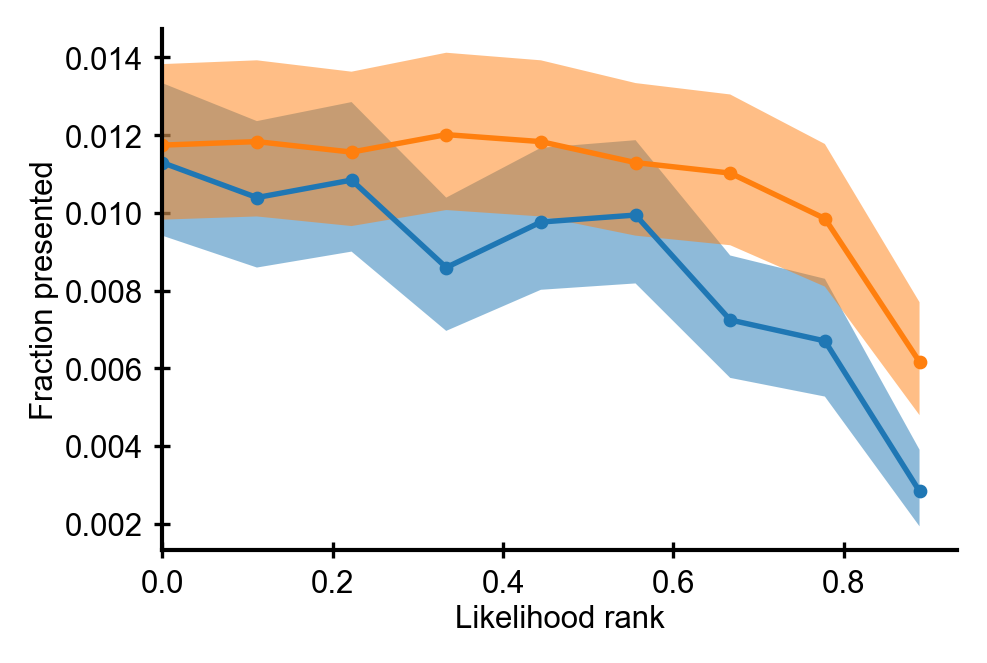

In [142]:
bins = histedges_equalN(probs['pathogen'], 10)[1:-1]
for hla in hlas.sample(10):
    print(hla)
    fig, ax = plt.subplots()
    for proteome in ['human', 'pathogen']:
        #prob = prob_ratios[proteome]
        prob = probs[proteome]

        df = pd.read_csv('data/{proteome}-{hla}.csv'.format(proteome=proteome, hla=hla),
                         sep='\t', skiprows=1)
        bins = np.linspace(0, 1, 10)
        tl.regplot(scipy.stats.rankdata(prob)/len(prob),#prob,
                   np.array(df['nM'])<500, bins=bins)
    ax.set_xlabel('Likelihood rank')
    ax.set_ylabel('Fraction presented')
    ax.set_xlim(0.0)

<AxesSubplot:>

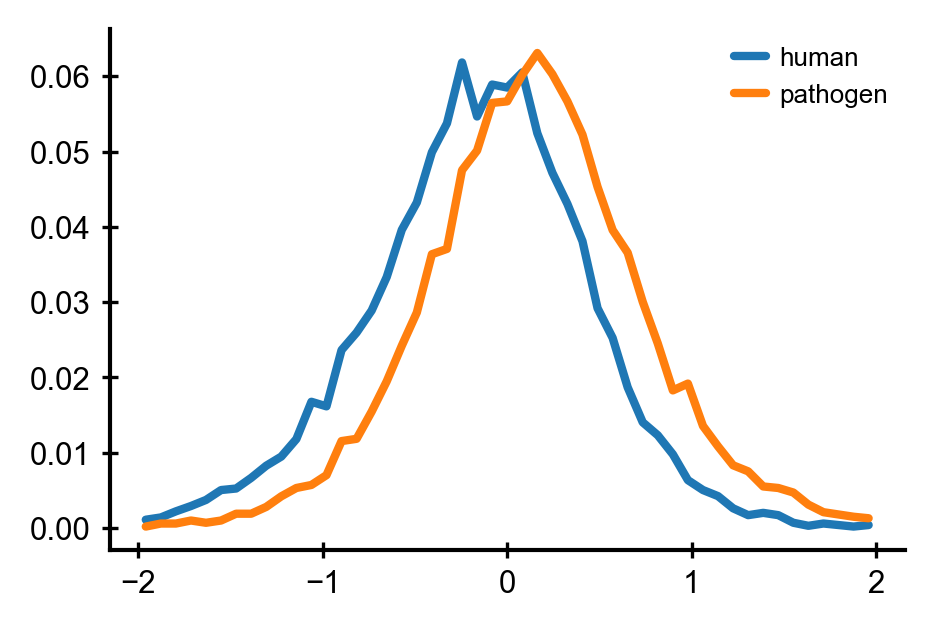

In [10]:
fig, ax = plt.subplots()
plot_histograms([prob_ratio_human, prob_ratio_pathogen],
                ['human', 'pathogen'],
                nbins=50, lw=2,
                xmin=-2, xmax=2, ax=ax, step=False)

In [13]:
background = np.mean(prob_ratio_pathogen) - np.mean(prob_ratio_human)

In [14]:
dkls = []
ratios = []
for hla in dfhla['name']:
    dfs = {}
    for proteome in ['human', 'pathogen']:
        df = pd.read_csv('data/{proteome}-{hla}.csv'.format(proteome=proteome, hla=hla), sep='\t', skiprows=1)
        dfs[proteome] = df
    ratio = np.sum(dfs['pathogen']['Rank'] < 10)/np.sum(dfs['human']['Rank'] < 10)
    ratios.append(ratio)
    dkl = np.mean(prob_ratio[dfs['pathogen']['Rank'] < 1]) - np.mean(prob_ratio_human[dfs['human']['Rank'] < 1])
    dkls.append(dkl)
    #print(hla, dkl, dp)

NameError: name 'prob_ratio' is not defined

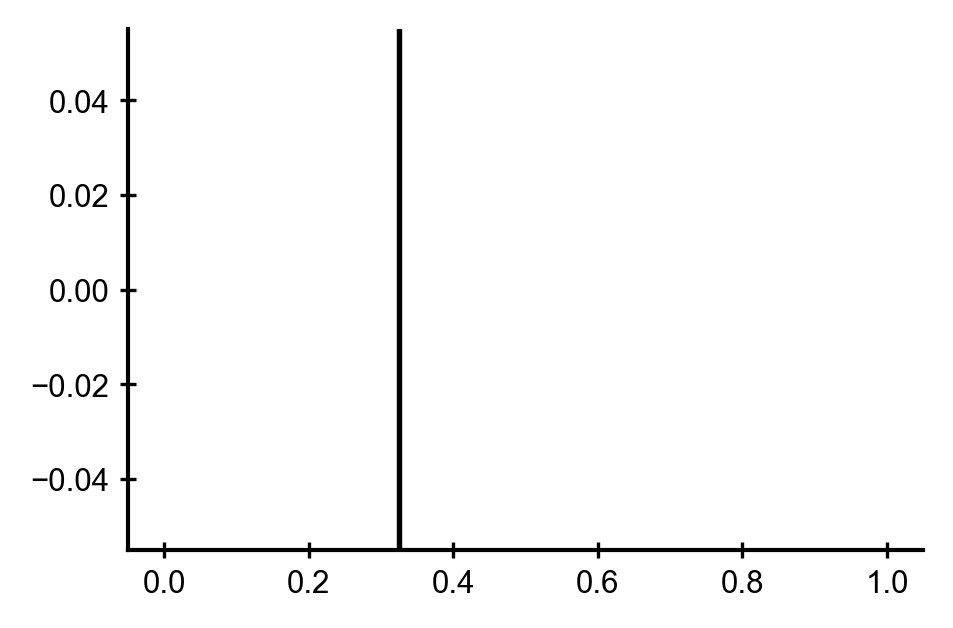

In [15]:
plt.hist(dkls)
plt.axvline(background, color='k');

NameError: name 'neg_ratio' is not defined

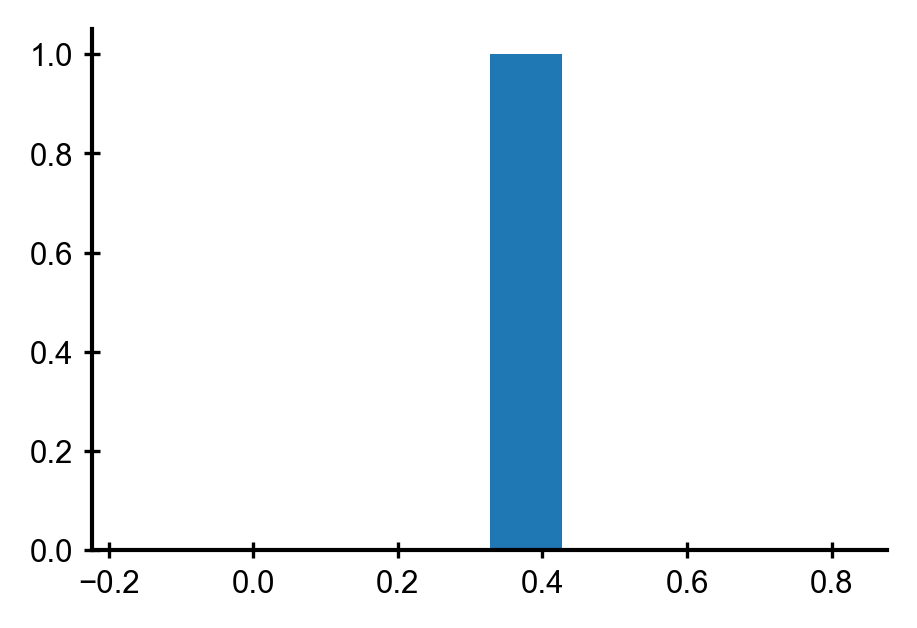

In [16]:
plt.hist(np.log2(ratios))
top_ratio = all_data['nskewfcov']['positive']
top_ratio = np.mean(neg_ratio[-int(0.1*len(neg_ratio)):])/np.log(2)
plt.axvline(top_ratio)

In [17]:
proteome = 'Humanviruses'
data = {}
for model in ['independent', 'nskewfcov']:
    arr = np.load('../classifier/data/{proteome}_{model}_k{k}_likelihoods.npz'.format(proteome=proteome,
                                                                                      model=model, k=k))
    data[model] = arr['logp_hh']

In [18]:
density_scatter(data['independent'], data['nskewfcov'])

<AxesSubplot:>

Error in callback <function flush_figures at 0x7fa406a45310> (for post_execute):


KeyboardInterrupt: 

In [ ]:
scipy.stats.spearmanr(data['independent'], data['nskewfcov'])